First we create Keras DataGenerator [ref]. This simply loads the images and generates batches of "batch_size" shuffling after each epoch. It has the option of passing in a "client_colm" which refers to the type of shard ("shard_iid" or "shard_non_iid") and a "num" argument which is the shard id, so we can have a separate data generator for each client.

In [ ]:
class DataGenerator(Sequence):
    'Generates data for Keras'
    def __init__(self, df_path, 
                 batch_size, 
                 img_size, 
                 n_classes,
                 client_colm=None,
                 num=None, 
                 shuffle=True):
        'Initialization'
        self.num = num
        self.shuffle = shuffle
        df = pd.read_csv(df_path)
        if num is not None:
            rows = df[df[client_colm]==self.num]
        else:
            rows = df
        self.batch_size = batch_size
        self.img_size = img_size
        self.n_classes = n_classes
        self.filenames = rows.filename.values
        self.labels = rows.label.values
        
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.ceil(len(self.filenames) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        # Generate data
        X, y = self.__data_generation(indexes)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.filenames))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, batch_inds):
        'Generates data containing batch_size samples' 
        # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.img_size))
        y = np.empty((self.batch_size), dtype=int)

        # Generate data
        for i, idx in enumerate(batch_inds):
            # Store sample
            # Omit alpha channel if any
            X[i,] =  plt.imread(self.filenames[idx])[...,:3]

            # Store class
            y[i] = self.labels[idx]

        return X, to_categorical(y, num_classes=self.n_classes)        


We use a simple ConvNet architecture based on the one introducted in the paper.

In [ ]:
def simple_cnn(img_size, n_classes):
        
    inputs = Input(img_size)
    conv1 = Conv2D(kernel_size=5, filters=32)(inputs)
    pool1 = MaxPooling2D(pool_size=2, strides=2)(conv1)
    conv2 = Conv2D(kernel_size=5, filters=64)(pool1)
    pool2 = MaxPooling2D(pool_size=2, strides=2)(conv2)
    flat = Flatten()(pool2)
    dense = Dense(units=512, activation='relu')(flat)
    out = Dense(units=n_classes, activation='softmax')(dense)
    model = Model(inputs=inputs, outputs=out)
    
    return model

The evaluation metric for the competition turns out to be accuracy [reference discussion] which is not the best metric for evaluating on unbalanced data but for consistency we will keep it for the experiments and also because although the distribution of classes is not uniform the proportions of different classes don’t wildly vary either.

In [ ]:
def get_model(config):
    model = simple_cnn(config.data.img_size, config.data.n_classes)
    model.compile(optimizer=SGD(lr=config.train.learning_rate),
                  loss='categorical_crossentropy',
                  metrics=['acc'])
    return model

# Baseline
As a baseline we will it on the full train dataset. You can find the code for this in `train_basic.py`. We won’t balance the batches or make much effort to optimise the model performance since as they note in the paper with regard to their CIFAR10 experiment "our goal is to evaluate our optimization method, not achieve the best possible accuracy on this task". This model converges to a little over 60% accuracy, starting to overfit about a third of the way through.

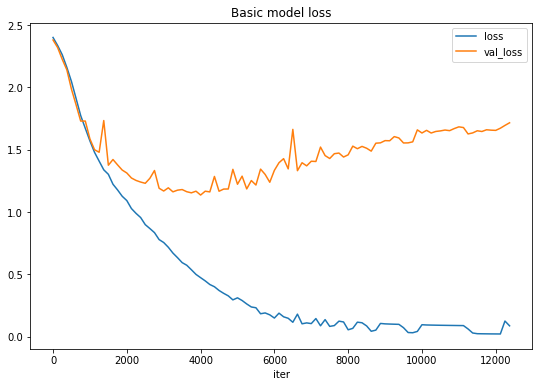

In [33]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
basic_log = pd.read_csv('./results/01-basic/csvlogs/trainval')
basic_log = basic_log.assign(**{'iter': basic_log.epoch * 125})
fig, ax = plt.subplots(1, figsize=(9, 6))
basic_log.plot(x='iter', y=['loss', 'val_loss'], ax=ax, title='Basic model loss');

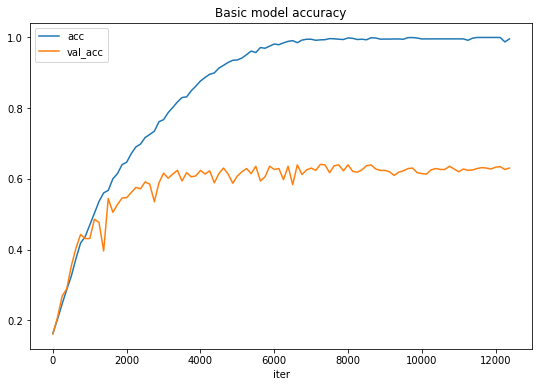

In [34]:
fig, ax = plt.subplots(1, figsize=(9, 6))
basic_log.plot(x='iter', y=['acc', 'val_acc'], ax=ax, title='Basic model accuracy');

We use the easydict module to define our configuration as EasyDicts since (as the name implies) it is convenient to access and to define attributes, particularly nested attributes.

In [ ]:
config = EasyDict(
{
 'mode': 'basic',
 'data': {
     'train_df_path' : 'train_resized.csv',
     'val_df_path': 'val_resized.csv',
     'img_size': (256, 256, 3),
     'batch_size': 32,
     'n_classes': 12,
     
 },
 'train' : {
     'learning_rate': 1e-3,
      'epochs': 100
 },
    'log': {
        'path': './results/01-basic',
        'update_freq': 5
    },
}
)

## Federated averaging
You can find the entire training script here. I will go through the most important parts. The key ideas are as follows:

- There are several **rounds** of training 
- A global model is initialised
- During each round of training local models are trained on a small number of randomly chosen clients with a given **batch size** and **number of epochs**.
- The global model is updated with the weighted average of the weights from the local models of the chosen clients.

We implement the following algorithm [picture] from the paper in the function ```fed_averaging```. 

The core of ```fed_averaging``` is as follows

In [ ]:
for t in range(1, config.train.num_rounds + 1):
    print('Round {}'.format(t))
    print('-' * 10)
    print('Training')
    global_weights = model.get_weights()
    _global_weights = [i.copy() for i in global_weights]
    m = int(np.ceil(max(config.train.client_fraction * config.train.num_clients, 1)))
    clients = np.random.permutation(config.train.num_clients)[:m]
    local_results = []

    for i, client in enumerate(clients):
        model.set_weights(global_weights)
        results = client_update(config, client, model)
        local_results.append(results)


    local_weights, n_examples, _tloss, _tacc = zip(*local_results)
    tloss = np.mean(_tloss)
    tacc = np.mean(_tacc)
    model.set_weights(average_weights(local_weights, n_examples))

Since our goal is to understand how the model performs when trained in this manner with different partitions of the data rather than to create a real federated learning setup with clients on different machines communicating with a server, we simulate the broadcasting step. We reset the weights of the model to the global_weights each time before training with the client data via `client_update` then saving the client models' weights in `local_weights`. Once we have gone through all the clients we aggregrate the weights with weighted averaging and set these as the global model weights.

## Client update

The client update is a normal training setup with respect to the data in the client. We train a model for a small number of epochs and then return the weights and the number of examples in the client (plus some metrics).

In [ ]:
def client_update(config, num, model):
    print(num)
    print(pd.DataFrame(pd.read_csv(config.data.train_df_path).query('{}=={}'.format(
        config.data.client_column, num)).label.value_counts()).T)
    dataset = DataGenerator(df_path=config.data.train_df_path, 
                          batch_size=config.data.batch_size, 
                          img_size=config.data.img_size, 
                          n_classes=config.data.n_classes,
                          client_colm=config.data.client_column,
                          num=num)
    history = model.fit_generator(dataset, 
                        epochs=config.train.epochs, 
                        verbose=True,
                        workers=4, 
                        use_multiprocessing=True)
    weights = model.get_weights()
    return (weights,
            len(dataset.filenames),
            history.history['loss'][-1], 
            history.history['acc'][-1])

## Weight averaging

Since the weights tend to have defined shapes to update the global weights conveniently we independently average each weight tensor across the sets of weights enabling us to return an aggregated set of weights of the same form as the individual sets of weights.

In [188]:
def average_weights(weights, n_examples):
    weight_lists = map(list, zip(*weights))
    total_examples = np.sum(n_examples)
    return [np.sum(np.stack(w, axis=-1) * n_examples, axis=-1) 
            / total_examples for w in weight_lists]

In [527]:
rand_log = pd.read_csv('./results/01-fed-non-iid/csvlogs/valid').iloc[:61]
rand_log_res = pd.read_csv('./results/01-fed-non-iid-resume/csvlogs/valid')
rand_log = pd.concat([rand_log, rand_log_res]).reset_index(drop=True)
rand_log = rand_log.assign(iter=(rand_log['round'] * 200))
rand_log2 = pd.read_csv('./results/01-fed-rand/csvlogs/valid')
rand_log2 = rand_log2.assign(iter=(rand_log2['round'] * 200))
rand_log_dec = pd.read_csv('./results/02-fed-non-iid/csvlogs/valid')

# Results [WIP]

Models are compared based on the number of weight updates needed for the model to reach a certain level of performance. For the standard model each mini-batch leads to an update while for the federated learning models the global model is updated after each communication round. For the randomly sampled shards it takes only 27 rounds to reach the highest accuracy attained by the baseline model of 64.06 % which takes more than 7000 minibatch updates. The model trained on non-representative shard clients did not manage to reach the baseline performance for the number of rounds it was trained. However at lower scores it matches the performance of the baseline after fewer rounds. The baseline reaches above 50% accuracy after more than 1500 updates whereas this model takes a little over 150 rounds. I stopped training as it looked like it was overfitting but them could potentially be tuned to perform better.

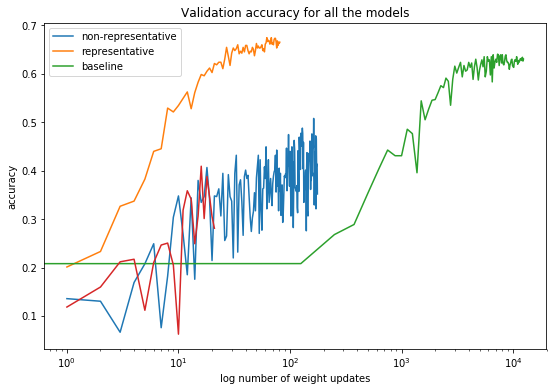

In [528]:
fig, ax = plt.subplots(1, figsize=(9, 6))
rand_log.plot(x='round', y=['acc'], ax=ax, logx=True);
rand_log2.plot(x='round', y=['acc'], ax=ax, logx=True);
basic_log.plot(x='iter', y=['val_acc'], ax=ax, logx=True);
rand_log_dec.plot(x='round', y=['acc'], ax=ax, logx=True, title='Random federated model validation acc');
ax.set_xlabel('log number of weight updates');
ax.set_ylabel('accuracy');
ax.set_title('Validation accuracy for all the models');
plt.legend(['non-representative', 'representative', 'baseline']);
#ax.set_xlim([10, basic_log['iter'].max()])


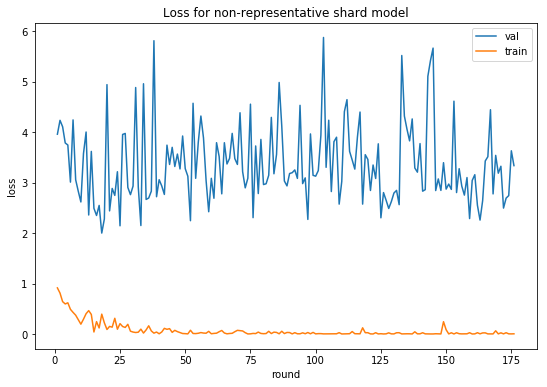

In [529]:
fig, ax = plt.subplots(1, figsize=(9, 6))
rand_log.plot(x='round', y=['loss'], ax=ax);


trand_log = pd.read_csv('./results/01-fed-non-iid/csvlogs/train').iloc[:61]
trand_log_res = pd.read_csv('./results/01-fed-non-iid-resume/csvlogs/train')
trand_log = pd.concat([trand_log, trand_log_res]).reset_index(drop=True)
trand_log.plot(x='round', y=['loss'], ax=ax);
plt.title('Loss for non-representative shard model')
plt.ylabel('loss');
ax.legend(['val', 'train']);

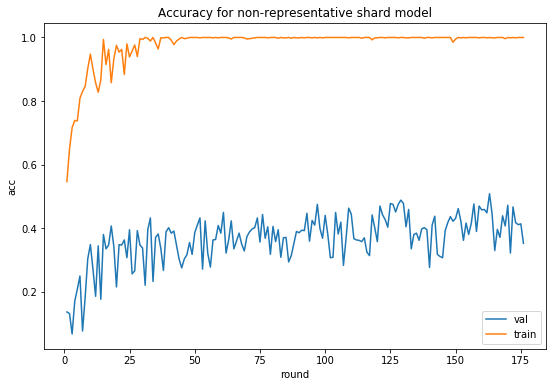

In [530]:
fig, ax = plt.subplots(1, figsize=(9, 6))
rand_log.plot(x='round', y=['acc'], ax=ax);


trand_log.plot(x='round', y=['acc'], ax=ax);
plt.title('Accuracy for non-representative shard model')
plt.ylabel('acc');
ax.legend(['val', 'train']);

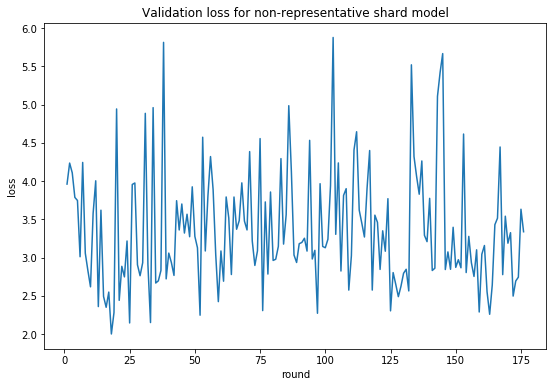

In [531]:
fig, ax = plt.subplots(1, figsize=(9, 6))
rand_log.plot(x='round', y=['loss'], ax=ax);
plt.title('Validation loss for non-representative shard model')
plt.ylabel('loss');
ax.get_legend().remove()

In [532]:
tx.aname

'Artist'

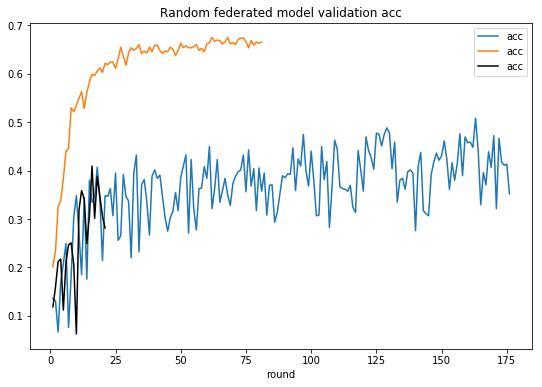

In [533]:
fig, ax = plt.subplots(1, figsize=(9, 6))
rand_log.plot(x='round', y=['acc'], ax=ax, title='Random federated model validation acc');
rand_log2.plot(x='round', y=['acc'], ax=ax, title='Random federated model validation acc');
rand_log_dec.plot(x='round', y=['acc'], ax=ax, title='Random federated model validation acc', color='k');

In [534]:
rand_log.head(10)

,round,loss,acc,iter
0,1.0,3.960418,0.136000,200.0
1,2.0,4.235252,0.130667,400.0
2,3.0,4.107892,0.066667,600.0
3,4.0,3.786401,0.169333,800.0
4,5.0,3.746186,0.208000,1000.0
5,6.0,3.010460,0.249333,1200.0
6,7.0,4.243645,0.076000,1400.0
7,8.0,3.057399,0.182667,1600.0
8,9.0,2.829191,0.304000,1800.0
9,10.0,2.617209,0.348000,2000.0


In [498]:
rand_log_dec.nlargest(10, 'acc')

,round,loss,acc
61,62.0,1.548336,0.465333
59,60.0,1.551261,0.462667
58,59.0,1.556242,0.462667
62,63.0,1.551269,0.461333
60,61.0,1.547548,0.461333
57,58.0,1.562506,0.460000
54,55.0,1.607668,0.452000
56,57.0,1.585134,0.450667
53,54.0,1.586427,0.449333
52,53.0,1.748437,0.440000


In [316]:
basic_log.loc[basic_log.val_acc.idxmax()] + 125

epoch        183.000000
acc          125.992500
loss         125.088656
val_acc      125.640625
val_loss     126.521232
iter        7375.000000
Name: 58, dtype: float64

In [317]:
rand_log2.query('acc > {}'.format(basic_log.val_acc.max()))['round'].min()

27.0

In [347]:
basic_log.query('val_acc > 0.5').nsmallest(1, 'iter')

,epoch,acc,loss,val_acc,val_loss,iter
12,12,0.56725,1.302839,0.544271,1.375807,1500


In [349]:
rand_log.query('acc > 0.5').nsmallest(1, 'round')

,round,loss,acc,iter
162,163.0,2.258167,0.508,32600.0


In [254]:
rand_log.loc[60]

round       61.000000
loss         2.690789
acc          0.449333
iter     12200.000000
Name: 60, dtype: float64

In [526]:
import numpy as np
t = np.arange(1000)
((0.99 ** t)[20] * 1e-3)

0.0008179069375972307

In [359]:
3e-4

0.0003

### 